In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import seaborn
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout
from tensorflow.keras.applications import DenseNet121

In [2]:
data_dir =r"E:\1. Thesis\PDD_MangoLeaf\Dataset"
keyword= ['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']

In [3]:
class_folders=os.listdir(data_dir)
image_paths=[]
labels=[]

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
                class_path=os.path.join(data_dir,class_folder)
                image_files=os.listdir(class_path)
                for image_file in image_files:
                    image_path=os.path.join(class_path,image_file)
                    image_paths.append(image_path)
                    labels.append(class_folder)
    
df=pd.DataFrame({'image_path':image_paths,'label':labels})
print("The classes:",np.unique(df['label']))

class_counts=df['label'].value_counts()
class_counts

The classes: ['Anthracnose' 'Bacterial Canker' 'Cutting Weevil' 'Die Back' 'Gall Midge'
 'Healthy' 'Powdery Mildew' 'Sooty Mould']


label
Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Die Back            500
Gall Midge          500
Healthy             500
Powdery Mildew      500
Sooty Mould         500
Name: count, dtype: int64

#### Modified BatchSize=32, split=60%+20%+20%, targetSize=128,128, lr=.00001

In [5]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [6]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(128,128)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(128,128))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [7]:
base_model = DenseNet121(weights='imagenet',include_top=False,input_shape=(128,128,3))

num_classes=8
base_model.trainable=True
#inputs=base_model.input
inputs = tf.keras.Input(shape=(128,128,3)) #Define input
x = base_model(inputs,training=False)     #pass input to base model
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs,outputs)  #Create model
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,095,304 (30.88 MB)

 Trainable params: 8,011,656 (30.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [9]:
epochs=10
training_history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)

C:\Users\Sanzida\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 631s 6s/step - accuracy: 0.3251 - loss: 1.9639 - val_accuracy: 0.5263 - val_loss: 1.5004
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 437s 6s/step - accuracy: 0.8236 - loss: 0.8398 - val_accuracy: 0.8338 - val_loss: 0.7452
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 451s 6s/step - accuracy: 0.9322 - loss: 0.4441 - val_accuracy: 0.9475 - val_loss: 0.3417
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 446s 6s/step - accuracy: 0.9447 - loss: 0.2769 - val_accuracy: 0.9725 - val_loss: 0.2004
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step - accuracy: 0.9754 - loss: 0.1675 - val_accuracy: 0.9837 - val_loss: 0.1133
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 432s 6s/step - accuracy: 0.9799 - loss: 0.1265 - val_accuracy: 0.9837 - val_loss: 0.0750
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 456s 6s/step - accuracy: 0.9871 - loss: 0.0985 - val_accuracy: 0.9962 - val_loss: 0.0475
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 427s 6s/step - accuracy: 0.9891 - loss: 0.0733 - val_accuracy: 0.9975 - v

In [10]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9987 - loss: 0.0214
Test Loss: 0.025673136115074158, Test Accuracy: 0.9975000023841858


In [11]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step
                  precision    recall  f1-score   support

     Anthracnose       1.00      0.99      1.00       117
Bacterial Canker       0.99      1.00      1.00       109
  Cutting Weevil       0.99      1.00      1.00       104
        Die Back       1.00      1.00      1.00        97
      Gall Midge       1.00      0.99      1.00       107
         Healthy       1.00      1.00      1.00        77
  Powdery Mildew       1.00      1.00      1.00        98
     Sooty Mould       1.00      1.00      1.00        91

        accuracy                           1.00       800
       macro avg       1.00      1.00      1.00       800
    weighted avg       1.00      1.00      1.00       800



25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step


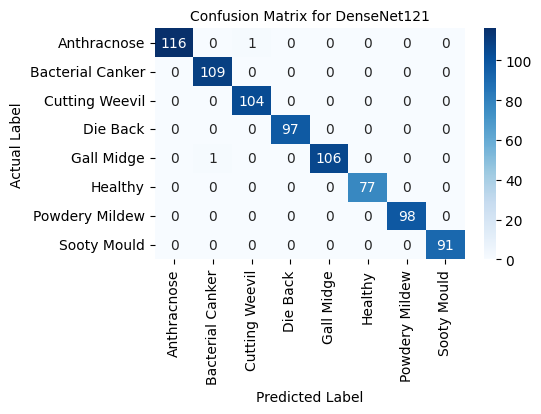

In [19]:
test_predictions=model.predict(test_generator)
trst_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,trst_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for DenseNet121',fontsize=10)
plt.show()

<Axes: >

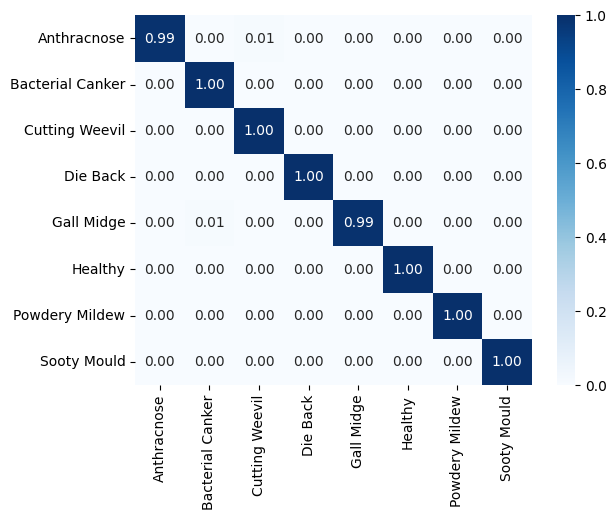

In [20]:
cmn=conf_matrix/conf_matrix.astype(float).sum(axis=1)
sns.heatmap(cmn,annot=True,fmt='.2f',cmap='Blues',xticklabels=class_names,yticklabels=class_names)

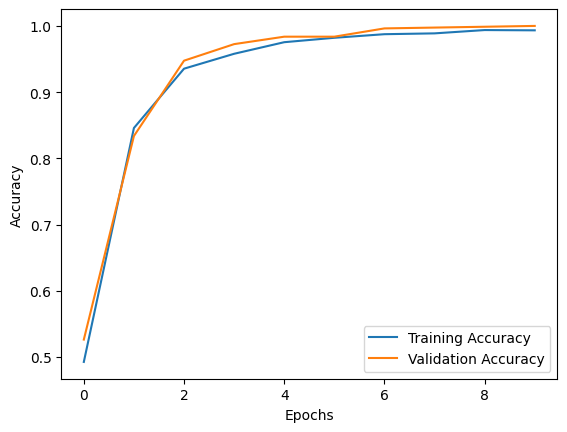

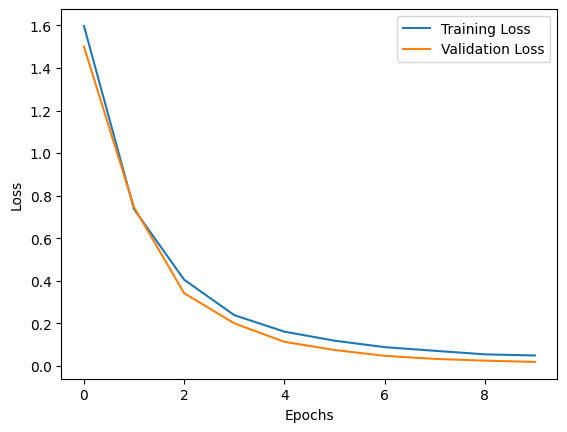

In [13]:
#plot training and validation accuracy
plt.plot(training_history.history['accuracy'],label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plot training and validation loss
plt.plot(training_history.history['loss'],label='Training Loss')
plt.plot(training_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Modified BatchSize=16, split=60%+20%+20%, targetSize=(128,128,3) lr=.001

In [21]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [22]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=16, target_size=(128,128)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df, val_df, test_df, batch_size=16, target_size=(128,128))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [43]:
num_classes=8
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable=False
#inputs=base_model.input
inputs = tf.keras.Input(shape=(128,128,3)) #Define input
x = base_model(inputs)     #pass input to base model
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs,outputs)  #Create model
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,095,304 (30.88 MB)

 Trainable params: 1,057,800 (4.04 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [45]:
epochs=10
training_history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 171s 987ms/step - accuracy: 0.7451 - loss: 0.8176 - val_accuracy: 0.9438 - val_loss: 0.1901
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 140s 931ms/step - accuracy: 0.9322 - loss: 0.2023 - val_accuracy: 0.9663 - val_loss: 0.0979
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 137s 916ms/step - accuracy: 0.9601 - loss: 0.1165 - val_accuracy: 0.9613 - val_loss: 0.1123
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 138s 917ms/step - accuracy: 0.9671 - loss: 0.1112 - val_accuracy: 0.9600 - val_loss: 0.0968
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 918ms/step - accuracy: 0.9767 - loss: 0.0711 - val_accuracy: 0.9712 - val_loss: 0.0778
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 145s 939ms/step - accuracy: 0.9807 - loss: 0.0596 - val_accuracy: 0.9625 - val_loss: 0.1309
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 148s 987ms/step - accuracy: 0.9837 - loss: 0.0579 - val_accuracy: 0.9688 - val_loss: 0.1008
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 138s 921ms/step - accuracy: 0.9734 -

In [46]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 792ms/step - accuracy: 0.9795 - loss: 0.0942
Test Loss: 0.09046909213066101, Test Accuracy: 0.9775000214576721


In [47]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 650ms/step
                  precision    recall  f1-score   support

     Anthracnose       0.97      1.00      0.98       117
Bacterial Canker       0.99      0.99      0.99       109
  Cutting Weevil       1.00      1.00      1.00       104
        Die Back       1.00      0.99      0.99        97
      Gall Midge       1.00      0.94      0.97       107
         Healthy       0.94      1.00      0.97        77
  Powdery Mildew       0.99      0.94      0.96        98
     Sooty Mould       0.93      0.96      0.94        91

        accuracy                           0.98       800
       macro avg       0.98      0.98      0.98       800
    weighted avg       0.98      0.98      0.98       800



50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 723ms/step


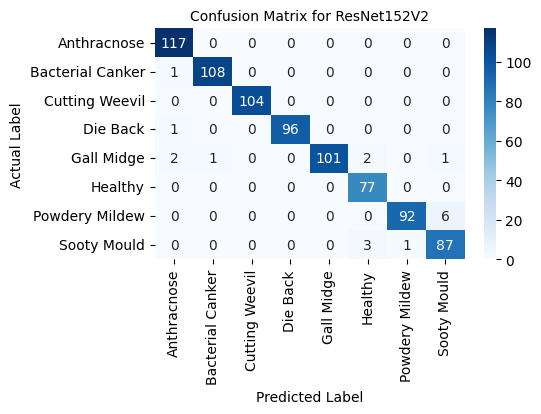

In [48]:
test_predictions=model.predict(test_generator)
trst_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,trst_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for ResNet152V2',fontsize=10)
plt.show()

<Axes: >

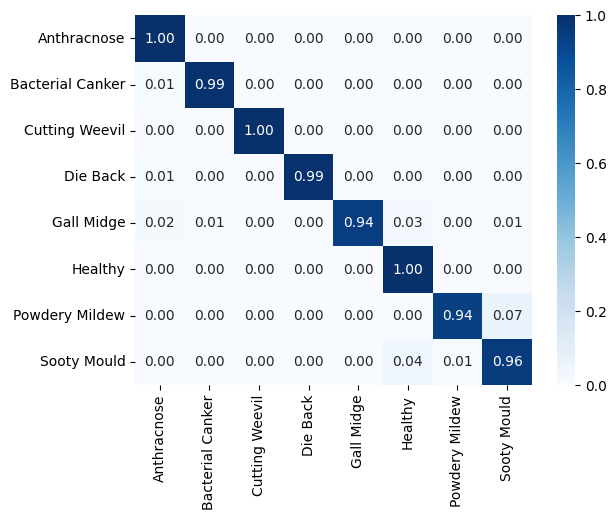

In [49]:
cmn=conf_matrix/conf_matrix.astype(float).sum(axis=1)
sns.heatmap(cmn,annot=True,fmt='.2f',cmap='Blues',xticklabels=class_names,yticklabels=class_names)

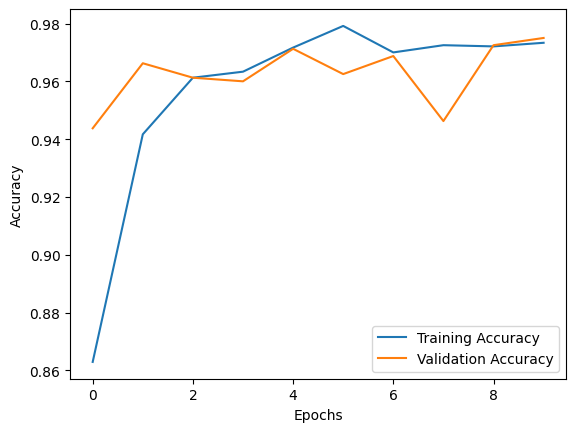

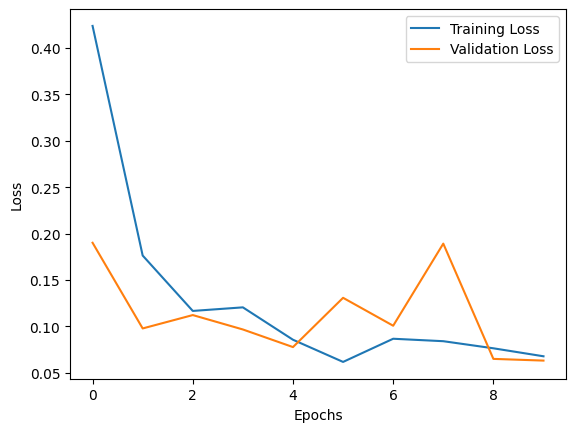

In [50]:
#plot training and validation accuracy
plt.plot(training_history.history['accuracy'],label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plot training and validation loss
plt.plot(training_history.history['loss'],label='Training Loss')
plt.plot(training_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

model.name="MangoLeaf_DenseNet121"
model.save('MangoLeaf_DenseNet121.keras')